In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

# Define your models
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier





In [36]:
# Load csv
df = pd.read_csv("players_data.csv", encoding='latin1')

In [37]:
#clean
df = df.drop_duplicates()
df.dropna(subset=['character', 'gameId', 'gameRank'], inplace=True)
df.fillna('Unknown', inplace=True)



In [38]:
# Create team ID
df['teamId'] = df['gameId'].astype(str) + "_" + df['gameRank'].astype(str)
df['win'] = df['gameRank'].apply(lambda x: 1 if x <= 3 else 0)



In [39]:
# Aggregate team composition and compute team stats
team_df = df.groupby('teamId').apply(lambda g: pd.Series({
    'gameId': g['gameId'].iloc[0],
    'gameRank': g['gameRank'].iloc[0],
    'win': g['win'].iloc[0],
    'characters': sorted(list(g['character'])),
    'kills': g['Kill'].sum(),
    'deaths': g['Death'].sum(),
    'assists': g['Assist'].sum(),
    'damage': g['Dmg_Player'].sum()
})).reset_index()

C:\Users\Zai\AppData\Local\Temp\ipykernel_6060\12169012.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  team_df = df.groupby('teamId').apply(lambda g: pd.Series({


In [40]:
team_sizes = df.groupby('teamId')['character'].count()
full_teams = (team_sizes == 3).sum()
incomplete_teams = (team_sizes != 3).sum()

print(f"Total teams: {len(team_sizes)}")
print(f"Full teams (3 players): {full_teams} ({(full_teams / len(team_sizes)):.2%})")
print(f"Incomplete teams: {incomplete_teams} ({(incomplete_teams / len(team_sizes)):.2%})")


Total teams: 89375
Full teams (3 players): 79003 (88.39%)
Incomplete teams: 10372 (11.61%)


In [41]:
# Keep only full teams
team_df = team_df[team_df['characters'].apply(len) == 3]

In [42]:
# Split characters into separate columns
team_df[['character1', 'character2', 'character3']] = pd.DataFrame(team_df['characters'].to_list(), index=team_df.index)
team_df.drop(columns=['characters', 'teamId', 'gameId', 'gameRank'], inplace=True)

In [43]:
print(team_df.head(10))

   win  kills  deaths  assists  damage      character1 character2 character3
0    1     13      11       21   62112           Adina     Lenore  Li Dailin
1    1      7      12       10   38223           Adela     Alonso      Yumin
2    1     11      10       13   46516           Cathy      Katja       Yuki
3    0      9       5       15   38821          Alonso     Celine       Hart
4    0      8      10       12   57173            Emma    Estelle      Katja
5    0      9       3       11   35192  Debi_&_Marlene      Fiora     Nadine
6    0      5       4        6   20419         Hyunwoo      Katja       Yuki
7    0      5       7        4   20290           Darko       Hart    Hyunwoo
8    1     21       0       35   89062         Abigail     Magnus    Shoichi
9    1      7      10       10   51343           Adina    Bernice    Hyunwoo


In [44]:
# Define features and target
X = team_df[['character1', 'character2', 'character3', 'kills', 'deaths', 'assists', 'damage']]
y = team_df['win']

In [45]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [46]:
# Preprocessing
categorical_features = ['character1', 'character2', 'character3']
numerical_features = ['kills', 'deaths', 'assists', 'damage']

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='passthrough')

In [49]:
# Model pipeline (RFC)
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      9520
           1       0.78      0.66      0.72      6281

    accuracy                           0.79     15801
   macro avg       0.79      0.77      0.77     15801
weighted avg       0.79      0.79      0.79     15801



In [19]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "SVC": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    print(f"Evaluating {name}...")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    
    scores = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=5,
        scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
        return_train_score=False
    )
    
    results[name] = {
        'accuracy': (scores['test_accuracy'].mean(), scores['test_accuracy'].std()),
        'precision': (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()),
        'recall': (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std()),
        'f1': (scores['test_f1_macro'].mean(), scores['test_f1_macro'].std())
    }

# Convert to DataFrame for easy viewing
import pandas as pd
results_df = pd.DataFrame(results).T.sort_values(by='f1', ascending=False)

# Split means and standard deviations into separate columns
results_df[['accuracy_mean', 'accuracy_std']] = pd.DataFrame(results_df['accuracy'].to_list(), index=results_df.index)
results_df[['precision_mean', 'precision_std']] = pd.DataFrame(results_df['precision'].to_list(), index=results_df.index)
results_df[['recall_mean', 'recall_std']] = pd.DataFrame(results_df['recall'].to_list(), index=results_df.index)
results_df[['f1_mean', 'f1_std']] = pd.DataFrame(results_df['f1'].to_list(), index=results_df.index)

# Drop the original columns containing tuples
results_df = results_df.drop(columns=['accuracy', 'precision', 'recall', 'f1'])

Evaluating Random Forest...
Evaluating Gradient Boosting...
Evaluating Logistic Regression...


c:\Users\Zai\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Zai\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Evaluating Decision Tree...
Evaluating SVC...
Evaluating KNN...
Evaluating AdaBoost...


c:\Users\Zai\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Zai\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Zai\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Zai\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecat

Evaluating Extra Trees...
Evaluating XGBoost...


c:\Users\Zai\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [00:49:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Zai\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [00:49:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Zai\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [00:49:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Zai\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [00:49:26] WARNING: C:\actions-runne

Evaluating LightGBM...
[LightGBM] [Info] Number of positive: 20098, number of negative: 30463
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 792
[LightGBM] [Info] Number of data points in the train set: 50561, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.397500 -> initscore=-0.415893
[LightGBM] [Info] Start training from score -0.415893
[LightGBM] [Info] Number of positive: 20098, number of negative: 30463
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 796
[LightGBM] [Info] Number of data points in the train set: 50561, number of used features: 218
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.397500 -> initscore=-0.415893
[LightGBM] [Info] Start training from score

In [1]:
print(results_df)

NameError: name 'results_df' is not defined

In [15]:
# Sample a portion of the training data to speed up evaluation
SAMPLE_SIZE = 20000  # adjust as needed
X_sampled = X_train.sample(n=SAMPLE_SIZE, random_state=42)
y_sampled = y_train.loc[X_sampled.index]

#lighter
models = {
    "Random Forest": RandomForestClassifier(n_jobs=-1, random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_jobs=-1, random_state=42),
    "XGBoost": XGBClassifier(n_jobs=-1, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(n_jobs=-1, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"Evaluating {name}...")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    
    scores = cross_validate(
        pipeline,
        X_sampled,
        y_sampled,
        cv=3,  # Reduced from 5 to 3 for speed
        scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
        return_train_score=False,
        n_jobs=-1  # Parallel processing
    )
    
    results[name] = {
        'accuracy': (scores['test_accuracy'].mean(), scores['test_accuracy'].std()),
        'precision': (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()),
        'recall': (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std()),
        'f1': (scores['test_f1_macro'].mean(), scores['test_f1_macro'].std())
    }

results_df = pd.DataFrame(results).T.sort_values(by='f1', ascending=False)
results_df[['accuracy_mean', 'accuracy_std']] = pd.DataFrame(results_df['accuracy'].to_list(), index=results_df.index)
results_df[['precision_mean', 'precision_std']] = pd.DataFrame(results_df['precision'].to_list(), index=results_df.index)
results_df[['recall_mean', 'recall_std']] = pd.DataFrame(results_df['recall'].to_list(), index=results_df.index)
results_df[['f1_mean', 'f1_std']] = pd.DataFrame(results_df['f1'].to_list(), index=results_df.index)
results_df = results_df.drop(columns=['accuracy', 'precision', 'recall', 'f1'])


Evaluating Random Forest...
Evaluating Gradient Boosting...
Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating AdaBoost...
Evaluating Extra Trees...
Evaluating XGBoost...
Evaluating LightGBM...


In [16]:
print(results_df)

                     accuracy_mean  accuracy_std  precision_mean  \
AdaBoost                   0.79100      0.001409        0.784890   
Gradient Boosting          0.79275      0.001193        0.789767   
LightGBM                   0.78925      0.000519        0.785396   
Logistic Regression        0.78805      0.003036        0.782446   
Random Forest              0.78800      0.002612        0.782697   
XGBoost                    0.78345      0.001978        0.777861   
Extra Trees                0.77640      0.002959        0.770676   
Decision Tree              0.71825      0.006300        0.704765   

                     precision_std  recall_mean  recall_std   f1_mean  \
AdaBoost                  0.001448     0.769931    0.002041  0.775323   
Gradient Boosting         0.001483     0.768048    0.001291  0.775056   
LightGBM                  0.001129     0.764853    0.000609  0.771547   
Logistic Regression       0.003574     0.765619    0.002925  0.771459   
Random Forest         

Evaluating Random Forest...
Evaluating Gradient Boosting...
Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating AdaBoost...
Evaluating Extra Trees...
Evaluating XGBoost...
Evaluating LightGBM...


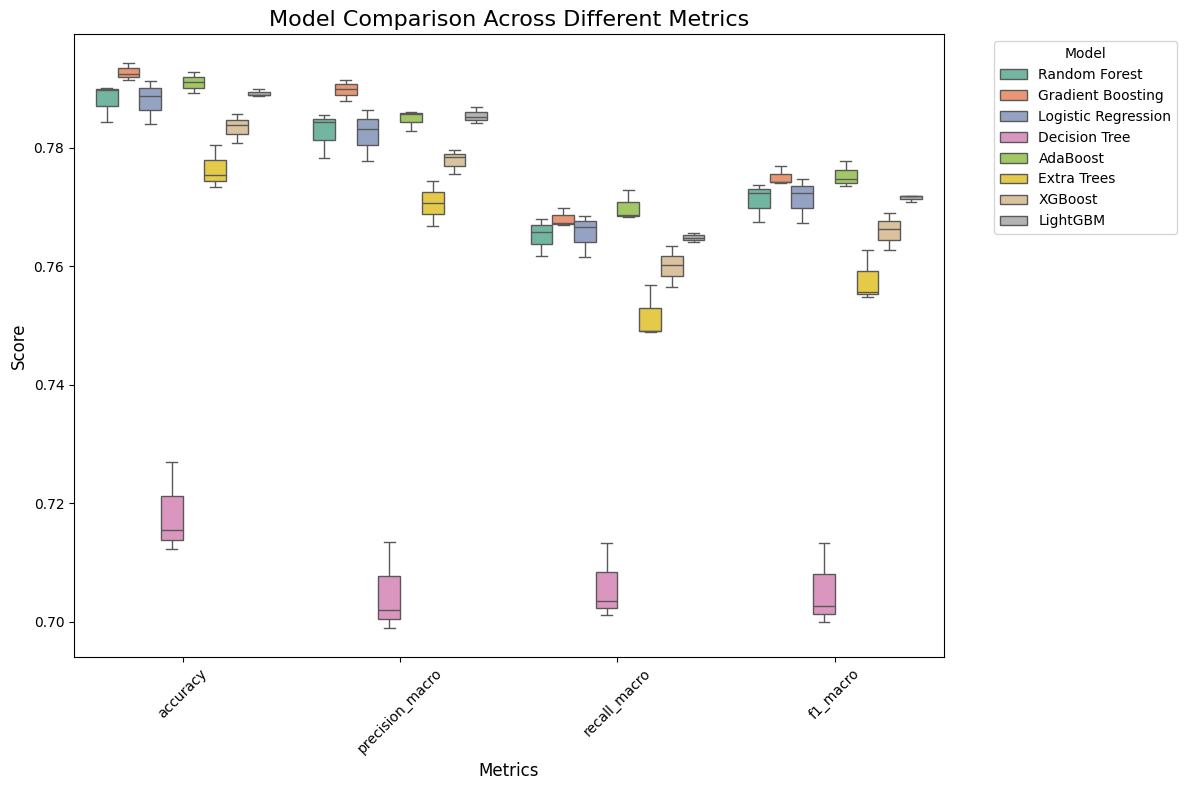

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Cross-validation results to store in a format suitable for boxplots
cv_results = {
    'model': [],
    'metric': [],
    'score': []
}

# Evaluate each model using cross-validation and store results for boxplots
for name, model in models.items():
    print(f"Evaluating {name}...")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

    # Cross-validation with sampling and parallel processing
    scores = cross_validate(
        pipeline,
        X_sampled,
        y_sampled,
        cv=3,  # 3-fold CV for speed
        scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
        return_train_score=False,
        n_jobs=-1  # Parallel processing
    )

    # Collect the scores for each metric
    for metric in ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']:
        cv_results['model'].extend([name] * 3)  # 3 folds
        cv_results['metric'].extend([metric] * 3)  # 3 folds
        cv_results['score'].extend(scores[f'test_{metric}'])  # 3 fold scores

# Convert to DataFrame for easier plotting
cv_results_df = pd.DataFrame(cv_results)

# Set up the figure and axes
plt.figure(figsize=(12, 8))

# Create the boxplot
sns.boxplot(x='metric', y='score', hue='model', data=cv_results_df, palette='Set2')

# Set titles and labels
plt.title('Model Comparison Across Different Metrics', fontsize=16)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


In [48]:
# Model pipeline (AdaBoost)
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(random_state=42))
])

# Fit the model
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


c:\Users\Zai\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.81      0.87      0.84      9520
           1       0.77      0.68      0.73      6281

    accuracy                           0.79     15801
   macro avg       0.79      0.78      0.78     15801
weighted avg       0.79      0.79      0.79     15801



In [55]:
# Prediction function
def predict_win_rate(char1, char2, char3, kills=0, deaths=0, assists=0, damage=0):
    chars = sorted([char1, char2, char3])
    input_df = pd.DataFrame([{
        'character1': chars[0],
        'character2': chars[1],
        'character3': chars[2],
        'kills': kills,
        'deaths': deaths,
        'assists': assists,
        'damage': damage
    }])
    prob = clf.predict_proba(input_df)[0][1]
    return f"Estimated Win Probability (Top 3): {prob:.2%}"

In [57]:
# Example usage
print(predict_win_rate("Adina", "Lenore", "Li Dailin"))

Estimated Win Probability (Top 3): 37.00%
